## Generating Training and Test Data for the Mass-Spring-Damper Model 

In [79]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import cantera as ct
from scipy.integrate import solve_ivp

3.8.9 (default, Apr  3 2021, 01:51:00) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [84]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data_100SMD_Clean/'
TestDir    = WORKSPACE_PATH+'/ROMNet/Data_100SMD_Clean_Test/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
try:
    os.makedirs(TestDir)
except OSError as e:
    pass

NTraining  = 100
NTest      = 10  
Nt         = 100
tout       = np.linspace(0.,15.,Nt)
SOLVER     = 'Radau'

In [85]:
### Defining ODE and its Parameters

def fOrig(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

def fOrig_Source(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

Params = np.array([1.0, 0.5, 3.0], dtype=np.float64)

y0 =  [0.165942   0.13090206]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.41117292 0.06213781]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.63919276 -0.03644707]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.96158173 0.47547959]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.74452806 0.9069221 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.075683    0.41869788]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.07622467 0.75810168]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.94932738 -0.84982831]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.9854186  0.83466087]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.25919315  0.94826309]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.92534634 0.78832292]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.77890202 -0.16758589]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.98705883 0.51484679]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.34442561  0.76595881]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.54768488  0.07181415]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.08329966 -0.59866742]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.18017212 -0.1761039 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.74804762 -0.87450394]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.96627066 0.66279131]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.12030481 -0.61519214]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.1523571  0.97066309]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.84711151 0.78016798]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.56604717 0.57289753]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.15306164 -0.52048395]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.971139   0.25898583]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.74440381 0.56910482]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.09870911 -0.54856611]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.32305708 -0.46172111]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.54654779 0.00456124]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.61417922 0.281675  ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.02439549 0.62654181]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.46220495 0.53946547]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.77195755  0.28630699]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.28523429  0.12801103]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.68566789 -0.06054154]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.24619564 -0.7309582 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.98457676 -0.50878945]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.81046004 -0.07503831]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.94055944 -0.06843894]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.18330966 -0.31376804]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.79505631  0.73391103]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.61006874  0.16530685]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.4121019   0.29379431]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.13794929 0.9081759 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.25939568 -0.30468358]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.71229364  0.35457258]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.40984027 0.08051318]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.38354405 0.17523571]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.41883865 -0.05925057]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.44506199 -0.6787389 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.80480785 -0.78879116]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.72392454 -0.71356776]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.98130653 -0.41442488]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.89501565 -0.35078638]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.27655249 -0.64435248]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.50939138 0.84668858]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.65401333  0.61393658]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.66898557  0.97787839]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.2254995  0.92997182]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.92605354 -0.45660182]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.59302998  0.72926866]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.90817578 -0.66482933]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.27731542 0.33763468]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.07676789 -0.65751791]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.58546061 0.00621043]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.9268121   0.62881021]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.76338634  0.16272429]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.37291751  0.6869136 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.65706174 -0.32419663]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.87382716 0.63988972]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.0660691  -0.90520909]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.08615779 0.81710931]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.27200474 -0.90348881]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.75401272 -0.7167006 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.49897714 -0.25978507]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.08081356 0.52623029]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.09278993 0.09232334]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.29404828 -0.89652423]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.57893157 -0.80328405]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.26016776 -0.80718046]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.47199135 -0.80536737]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.532434   -0.74312705]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.85037479  0.71759961]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.86757877 0.98365368]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.68150574 0.60004851]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.82303802 0.69958426]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.90815173 0.05743063]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.62517422  0.38889139]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.37887033 -0.28921846]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.72312788 -0.97762654]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.04401443 0.19771236]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.79673456 -0.2738434 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.76539209 0.49985387]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.69000559 -0.59981486]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.35608082 0.96647187]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.18575119 -0.26310951]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.64442827 -0.45158403]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.87449315 -0.19462596]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.6261614  0.2057567]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.96705411 -0.87554807]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/sventuri/WORKSPACE//ROMNet/Data_100SMD_Clean//deeponet/Input.csv'

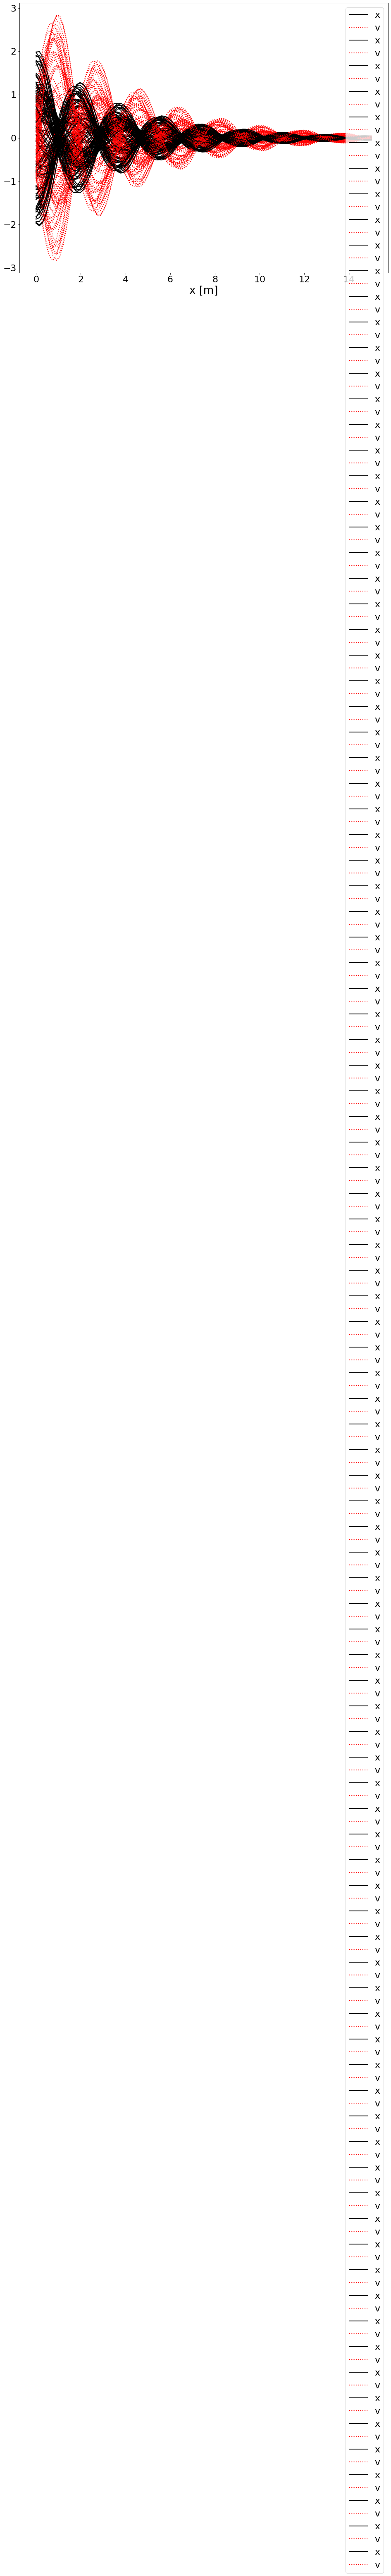

In [86]:
### Generating Training Data

# Sampling Initial Conditions
y0Mat      = np.zeros((NTraining,2))
y0Mat[:,0] = np.random.rand(NTraining)*4. - 2.0
y0Mat[:,1] = np.random.rand(NTraining)*2. - 1.0

fig   = plt.figure(figsize=(16, 12))
for iSample in range(NTraining):
    y0         = y0Mat[iSample,:]
    print('y0 = ', y0)
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0, method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    
    tMatTemp   = tout[...,np.newaxis]
    uMatTemp   = np.tile(y0, (Nt, 1))
    
    plt.plot(output.t, output.y[0,:], '-k', label='x')
    plt.plot(output.t, output.y[1,:], ':r', label='v')
    plt.legend()
    plt.xlabel('t [s]')
    plt.xlabel('x [m]')
        
    ySourceTemp = np.zeros_like(output.y)
    for it in range(Nt):
        ySourceTemp[:,it] = fOrig_Source(output.t, output.y[:,it])

    if (iSample == 0):
        tMat    = tMatTemp
        uMat    = uMatTemp
        yMat    = output.y.T 
        ySource = ySourceTemp.T
    else:
        tMat    = np.concatenate((tMat,    tMatTemp), axis=0)
        uMat    = np.concatenate((uMat,    uMatTemp), axis=0)
        yMat    = np.concatenate((yMat,    output.y.T), axis=0)
        ySource = np.concatenate((ySource, ySourceTemp.T), axis=0)
        

y0 =  [ 1.60517973 -0.96233584]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.85657861  0.41476134]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.88016484 -0.79632923]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.06064961 -0.54281753]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.38427026 -0.9512555 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.45869698 0.0520381 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.21551046  0.56429813]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.75178252 -0.21018634]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.13927541  0.31718943]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [1.79081802 0.42959606]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/sventuri/WORKSPACE//ROMNet/Data_100SMD_Clean_Test//deeponet/Input.csv'

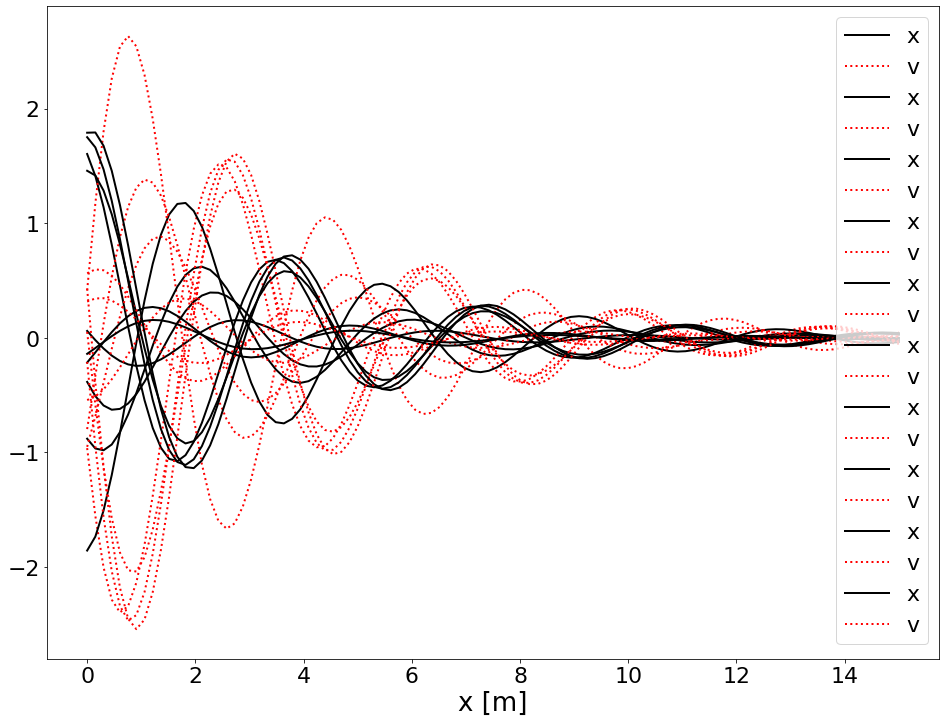

In [87]:
### Generating Training Data

# Sampling Initial Conditions
y0MatTest      = np.zeros((NTest,2))
y0MatTest[:,0] = np.random.rand(NTest)*4. - 2.0
y0MatTest[:,1] = np.random.rand(NTest)*2. - 1.0


fig   = plt.figure(figsize=(16, 12))
for iSample in range(NTest):
    y0         = y0MatTest[iSample,:]
    print('y0 = ', y0)
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0, method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    
    tMatTemp   = tout[...,np.newaxis]
    uMatTemp   = np.tile(y0, (Nt, 1))
    
    plt.plot(output.t, output.y[0,:], '-k', label='x')
    plt.plot(output.t, output.y[1,:], ':r', label='v')
    plt.legend()
    plt.xlabel('t [s]')
    plt.xlabel('x [m]')
        
    ySourceTemp = np.zeros_like(output.y)
    for it in range(Nt):
        ySourceTemp[:,it] = fOrig_Source(output.t, output.y[:,it])

    if (iSample == 0):
        tMatTest    = tMatTemp
        uMatTest    = uMatTemp
        yMatTest    = output.y.T 
        ySourceTest = ySourceTemp.T
    else:
        tMatTest    = np.concatenate((tMatTest,    tMatTemp), axis=0)
        uMatTest    = np.concatenate((uMatTest,    uMatTemp), axis=0)
        yMatTest    = np.concatenate((yMatTest,    output.y.T), axis=0)
        ySourceTest = np.concatenate((ySourceTest, ySourceTemp.T), axis=0)
        

In [96]:
### Saving Data

Header   = 't,x,v'
FileName = OutputDir+'/Input.csv'
np.savetxt(FileName, np.concatenate((tMat,uMat), axis=1), delimiter=',', header=Header, comments='')
        
Header   = 'x,v'
FileName = OutputDir+'/Output.csv'
np.savetxt(FileName, yMat, delimiter=',', header=Header, comments='')

Header   = 'dx,dv'
FileName = OutputDir+'/dOutput.csv'
np.savetxt(FileName, ySource, delimiter=',', header=Header, comments='')

Header   = 't,x,v'
FileName = TestDir+'/Input.csv'
np.savetxt(FileName, np.concatenate((tMatTest,uMatTest), axis=1), delimiter=',', header=Header, comments='')
        
Header   = 'x,v'
FileName = TestDir+'/Output.csv'
np.savetxt(FileName, yMatTest, delimiter=',', header=Header, comments='')

Header   = 'dx,dv'
FileName = TestDir+'/dOutput.csv'
np.savetxt(FileName, ySourceTest, delimiter=',', header=Header, comments='')

## Testing Surrogated-Sources Approach

In [88]:
### Importing Libraries

import tensorflow  as tf
from tensorflow.keras              import backend as K
from tensorflow.keras              import activations, initializers
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import Layer, Dense, Activation, Dropout
from tensorflow.keras              import Input
from tensorflow.keras.regularizers import l2

from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler

In [89]:
### Input Data

NNeurons           = [16,32,64,32,16]
Activations        = [activations.tanh, activations.tanh, activations.tanh, activations.tanh, activations.tanh]
NEpoch             = 10000
NBatch             = 64
LearningRate       = 5.e-4
OptimizerName      = tf.optimizers.Adam

Text(0.5, 0, 'dv/dt')

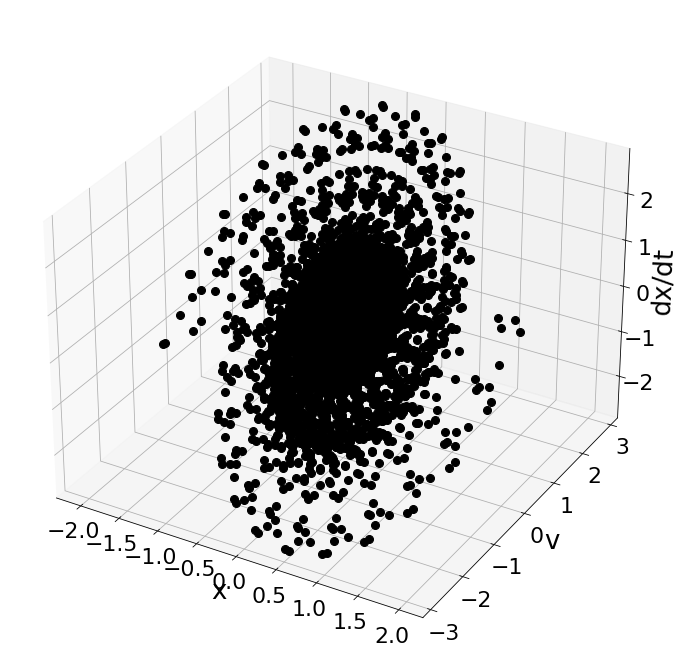

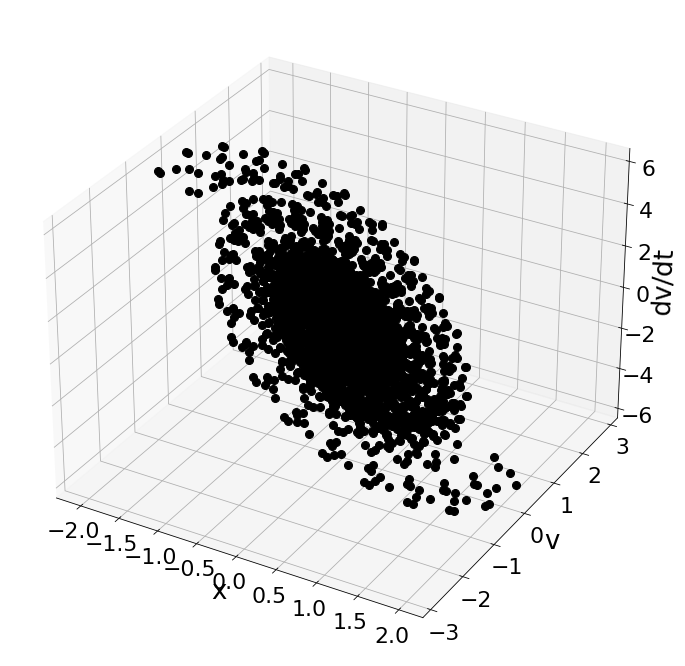

In [90]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat[:,0], yMat[:,1], ySource[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'x')
ax.set_ylabel(r'v')
ax.set_zlabel(r'dx/dt')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat[:,0], yMat[:,1], ySource[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'x')
ax.set_ylabel(r'v')
ax.set_zlabel(r'dv/dt')

In [91]:
### Normalizing Data

Nx = yMat.shape[1]
Nd = yMat.shape[0]
Ny = ySource.shape[1]

xMax     = yMat.max(0)
xMin     = yMat.min(0)
xRange   = (xMax-xMin)
yMatt    = (yMat-xMin)/xRange

yMax     = ySource.max(0)
yMin     = ySource.min(0)
yRange   = (yMax-yMin)
ySourcee = (ySource-yMin)/yRange

In [92]:
### Splitting Data

XTrain, XTest, yTrain, yTest = train_test_split(yMatt, ySourcee, test_size=0.2, random_state=3)

In [93]:
### Creating Surrogate

LengthScale               = 5.e-2
Tau                       = 1.
RegCoeff                  = LengthScale**2 * (1.) / (2. * Nd * Tau)

NNModel = tf.keras.models.Sequential()

NNModel.add(Dense(NNeurons[0], input_shape=(Nx,), activation=Activations[0], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
for iHL in range(1, len(NNeurons)):
    NNModel.add(Dense(NNeurons[iHL], activation=Activations[iHL], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
NNModel.add(Dense(Ny, activation='linear'))
NNModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 34        
Total params: 5,346
Trainable params: 5,346
Non-trainable params: 0
____________________________________________________

In [94]:
### Training Surrogate

Optimizer = OptimizerName(learning_rate=LearningRate)
NNModel.compile(optimizer=Optimizer, loss='mse')
Training         = NNModel.fit(XTrain, yTrain, batch_size=NBatch, epochs=NEpoch, validation_data=(XTest, yTest), verbose=1);

LossTrainHystory = Training.history['loss']
LossValidHystory = Training.history['val_loss']

# Plotting Training and Validation Loss
fig = plt.figure(figsize=(12, 8))
plt.plot(LossTrainHystory, 'r', label='Training')
plt.plot(LossValidHystory, 'g', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
FigPath = FigDir+'/fig/TrainingNN_'+str(NEpoch)+'Epoches_PCSources.png'
fig.savefig(FigPath, dpi=900)

Epoch 1/10000
125/125 [==============================] - 1s 3ms/step - loss: 0.0098 - val_loss: 0.0038
Epoch 2/10000
125/125 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 3/10000
125/125 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 2.1407e-04
Epoch 4/10000
125/125 [==============================] - 0s 2ms/step - loss: 8.7291e-05 - val_loss: 4.5025e-05
Epoch 5/10000
125/125 [==============================] - 0s 2ms/step - loss: 5.1906e-05 - val_loss: 4.2756e-05
Epoch 6/10000
125/125 [==============================] - 0s 2ms/step - loss: 4.8527e-05 - val_loss: 4.0115e-05
Epoch 7/10000
125/125 [==============================] - 0s 2ms/step - loss: 4.6240e-05 - val_loss: 4.1341e-05
Epoch 8/10000
125/125 [==============================] - 0s 2ms/step - loss: 4.3246e-05 - val_loss: 3.6566e-05
Epoch 9/10000
125/125 [==============================] - 0s 2ms/step - loss: 4.1498e-05 - val_loss: 3.4664e-05
Epoch 10/10000
125/12

Epoch 147/10000
125/125 [==============================] - 0s 3ms/step - loss: 1.6237e-05 - val_loss: 2.1906e-05
Epoch 148/10000
125/125 [==============================] - 0s 3ms/step - loss: 1.6289e-05 - val_loss: 1.5436e-05
Epoch 149/10000
125/125 [==============================] - 0s 2ms/step - loss: 1.5638e-05 - val_loss: 1.6174e-05
Epoch 150/10000
125/125 [==============================] - 0s 3ms/step - loss: 1.5996e-05 - val_loss: 1.6607e-05
Epoch 151/10000
125/125 [==============================] - 0s 2ms/step - loss: 1.6540e-05 - val_loss: 1.4736e-05
Epoch 152/10000
125/125 [==============================] - 0s 3ms/step - loss: 1.5180e-05 - val_loss: 1.4196e-05
Epoch 153/10000
125/125 [==============================] - 0s 2ms/step - loss: 1.6439e-05 - val_loss: 1.4392e-05
Epoch 154/10000
125/125 [==============================] - 0s 2ms/step - loss: 1.5703e-05 - val_loss: 1.5261e-05
Epoch 155/10000
125/125 [==============================] - 0s 2ms/step - loss: 1.5825e-05 - val_

125/125 [==============================] - 0s 3ms/step - loss: 1.1054e-05 - val_loss: 1.2840e-05
Epoch 292/10000
125/125 [==============================] - 0s 2ms/step - loss: 1.1459e-05 - val_loss: 1.0851e-05
Epoch 293/10000
125/125 [==============================] - 0s 3ms/step - loss: 1.0963e-05 - val_loss: 1.0740e-05
Epoch 294/10000
125/125 [==============================] - 0s 2ms/step - loss: 1.1004e-05 - val_loss: 1.0463e-05
Epoch 295/10000
125/125 [==============================] - 0s 2ms/step - loss: 1.0755e-05 - val_loss: 1.0173e-05
Epoch 296/10000
125/125 [==============================] - 0s 2ms/step - loss: 1.0643e-05 - val_loss: 1.1894e-05
Epoch 297/10000
125/125 [==============================] - 0s 2ms/step - loss: 1.1503e-05 - val_loss: 1.2602e-05
Epoch 298/10000
125/125 [==============================] - 0s 2ms/step - loss: 1.0588e-05 - val_loss: 1.0465e-05
Epoch 299/10000
125/125 [==============================] - 0s 3ms/step - loss: 1.0742e-05 - val_loss: 1.3535e-05

125/125 [==============================] - 0s 3ms/step - loss: 7.6696e-06 - val_loss: 1.0394e-05
Epoch 436/10000
125/125 [==============================] - 0s 3ms/step - loss: 8.2317e-06 - val_loss: 8.1304e-06
Epoch 437/10000
125/125 [==============================] - 0s 3ms/step - loss: 8.3504e-06 - val_loss: 8.7257e-06
Epoch 438/10000
125/125 [==============================] - 0s 3ms/step - loss: 7.4643e-06 - val_loss: 7.5679e-06
Epoch 439/10000
125/125 [==============================] - 0s 3ms/step - loss: 7.8967e-06 - val_loss: 9.2197e-06
Epoch 440/10000
125/125 [==============================] - 0s 3ms/step - loss: 7.8178e-06 - val_loss: 7.1451e-06
Epoch 441/10000
125/125 [==============================] - 0s 3ms/step - loss: 7.7634e-06 - val_loss: 6.9879e-06
Epoch 442/10000
125/125 [==============================] - 0s 3ms/step - loss: 7.3300e-06 - val_loss: 6.7239e-06
Epoch 443/10000
125/125 [==============================] - 0s 3ms/step - loss: 7.4351e-06 - val_loss: 7.1371e-06

125/125 [==============================] - 0s 3ms/step - loss: 5.6902e-06 - val_loss: 5.3820e-06
Epoch 580/10000
125/125 [==============================] - 0s 3ms/step - loss: 6.2884e-06 - val_loss: 5.2548e-06
Epoch 581/10000
125/125 [==============================] - 0s 3ms/step - loss: 5.8922e-06 - val_loss: 5.1344e-06
Epoch 582/10000
125/125 [==============================] - 0s 3ms/step - loss: 5.6748e-06 - val_loss: 5.4181e-06
Epoch 583/10000
125/125 [==============================] - 0s 2ms/step - loss: 5.9775e-06 - val_loss: 5.9256e-06
Epoch 584/10000
125/125 [==============================] - 0s 3ms/step - loss: 5.9862e-06 - val_loss: 5.8422e-06
Epoch 585/10000
125/125 [==============================] - 0s 4ms/step - loss: 6.4321e-06 - val_loss: 6.4844e-06
Epoch 586/10000
125/125 [==============================] - 0s 3ms/step - loss: 5.8915e-06 - val_loss: 5.5352e-06
Epoch 587/10000
125/125 [==============================] - 0s 3ms/step - loss: 6.1727e-06 - val_loss: 6.0266e-06

KeyboardInterrupt: 

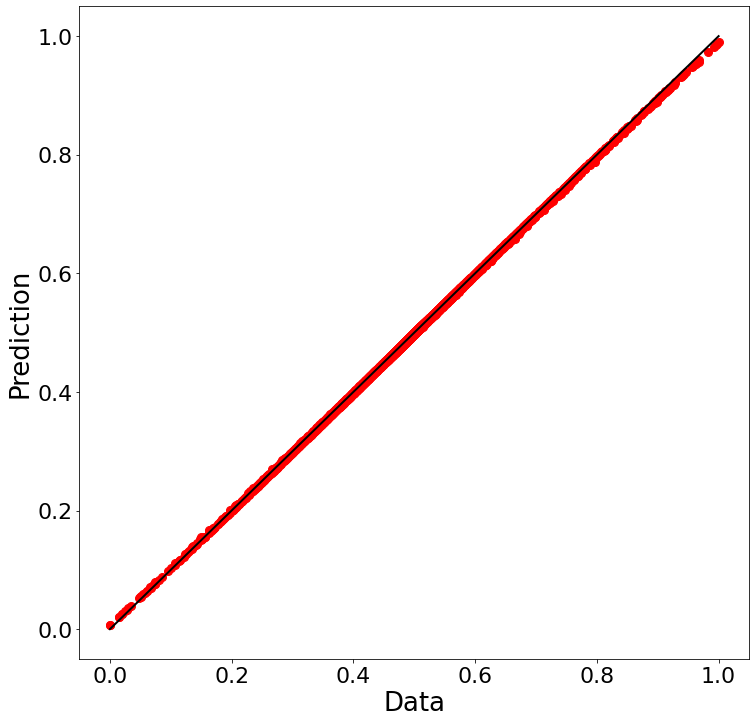

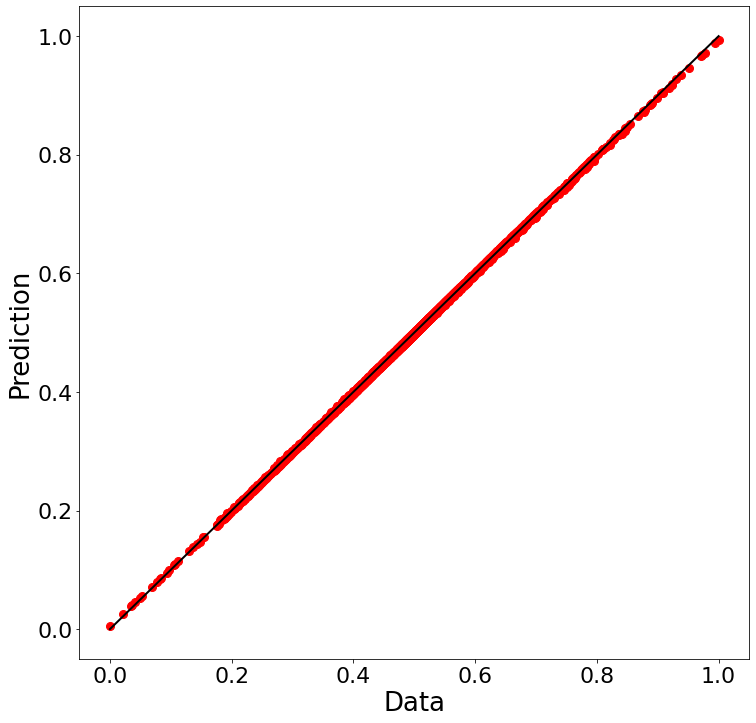

In [97]:
### Checking Predictive Accuracy

ySource_ = NNModel.predict(yMatt)

for iy in range(Ny):
    fig  = plt.figure(figsize=(12,12))
    xMin_ = np.amin(ySourcee[:,iy])
    xMax_ = np.amax(ySourcee[:,iy])
    plt.plot(ySourcee[:,iy], ySource_[:,iy], 'ro')
    plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
    plt.xlabel('Data')
    plt.ylabel('Prediction')

In [98]:
### Defining Surrogate ODE

def fOrig_NN(t, y):
    #print(t)
    yy   = (y - xMin)/xRange
    dydt = NNModel.predict(yy[np.newaxis,...])
    dydt = dydt*yRange + yMin
    return dydt[0,:]

/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


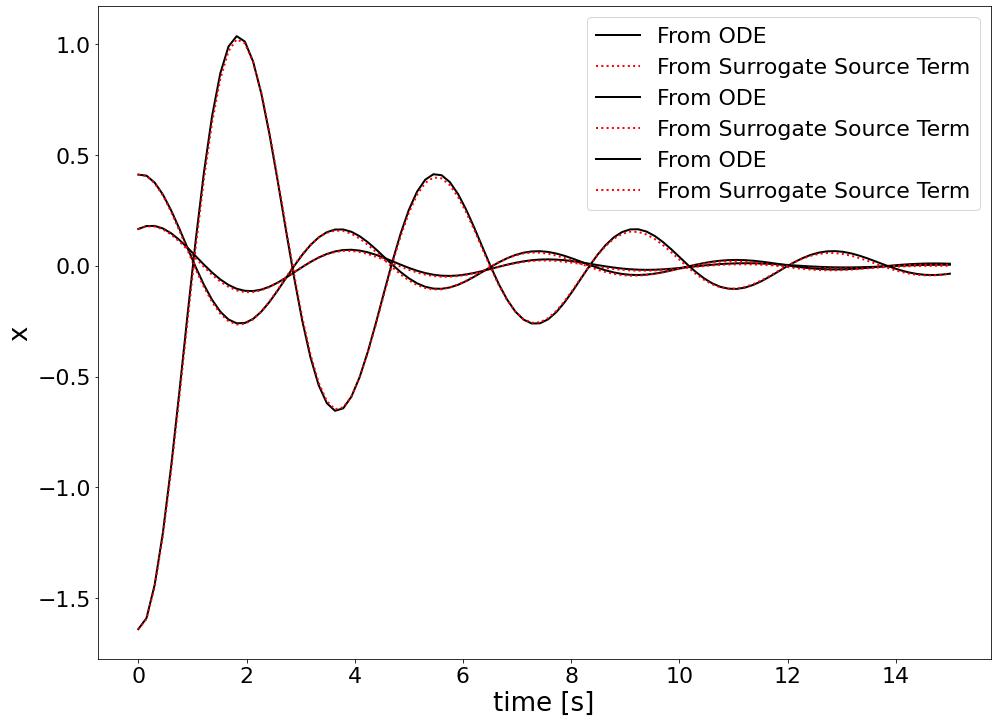

In [100]:
### Evaluating on Test Data

fig = plt.figure(figsize=(16,12))
for iTest in range(3):
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0Mat[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15 )
    tOrig      = output.t
    yMat       = output.y.T
    
    output     = solve_ivp( fOrig_NN, tout[[0,-1]], y0Mat[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15 )
    tNN        = output.t
    yMat_      = output.y.T
        
    plt.plot(tOrig, yMat[:,0], '-k', label='From ODE',                   lw=2)
    plt.plot(tNN, yMat_[:,0], ':r',  label='From Surrogate Source Term', lw=2)

plt.xlabel('time [s]')
plt.ylabel('x')
plt.legend()